Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import pickle


Load Dataset

In [3]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("Environment_Temperature_change_E_All_Data_NOFLAG.csv", encoding="ISO-8859-1")
df.head()


ModuleNotFoundError: No module named 'google.colab'

 Check and Clean Column Names

In [ ]:
print("Dataset Columns:", df.columns)
df.columns = df.columns.str.strip()


Dataset Columns: Index(['Area Code', 'Area', 'Months Code', 'Months', 'Element Code', 'Element',
       'Unit', 'Y1961', 'Y1962', 'Y1963', 'Y1964', 'Y1965', 'Y1966', 'Y1967',
       'Y1968', 'Y1969', 'Y1970', 'Y1971', 'Y1972', 'Y1973', 'Y1974', 'Y1975',
       'Y1976', 'Y1977', 'Y1978', 'Y1979', 'Y1980', 'Y1981', 'Y1982', 'Y1983',
       'Y1984', 'Y1985', 'Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991',
       'Y1992', 'Y1993', 'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999',
       'Y2000', 'Y2001', 'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007',
       'Y2008', 'Y2009', 'Y2010', 'Y2011', 'Y2012', 'Y2013', 'Y2014', 'Y2015',
       'Y2016', 'Y2017', 'Y2018', 'Y2019'],
      dtype='object')


Filter & Average "Temperature change"

In [ ]:
df = df[df['Element'] == 'Temperature change']
years = [col for col in df.columns if col.startswith('Y')]
df_avg = df[years].mean().reset_index()
df_avg.columns = ['Year', 'AvgTempChange']
df_avg['Year'] = df_avg['Year'].str.extract('(\d+)').astype(int)


 Exploratory Data Analysis

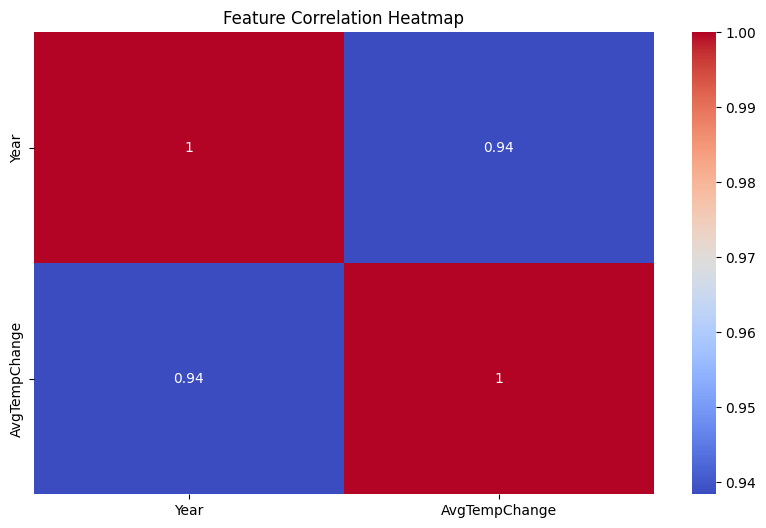

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_avg.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


Data Preprocessing

In [ ]:
df_avg.dropna(inplace=True)
X = df_avg[['Year']]
y = df_avg['AvgTempChange']


Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Train Linear Regression with Gradient Descent

In [ ]:
sgd = SGDRegressor(max_iter=1000, tol=1e-3, learning_rate='optimal')
sgd.fit(X_train, y_train)

train_losses = []
test_losses = []

for i in range(1, 100):
    sgd.partial_fit(X_train, y_train)
    train_pred = sgd.predict(X_train)
    test_pred = sgd.predict(X_test)
    train_losses.append(mean_squared_error(y_train, train_pred))
    test_losses.append(mean_squared_error(y_test, test_pred))


Plot Loss Curve

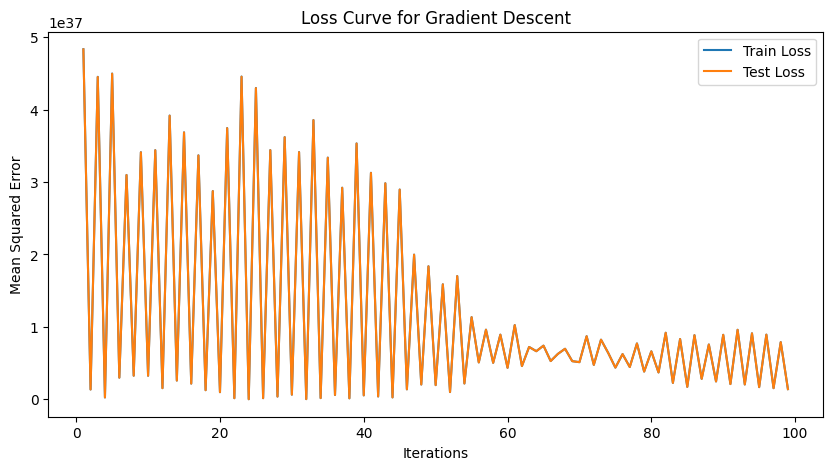

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100), train_losses, label='Train Loss')
plt.plot(range(1, 100), test_losses, label='Test Loss')
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error")
plt.title("Loss Curve for Gradient Descent")
plt.legend()
plt.show()


Train and Compare Other Models

In [ ]:
models = {
    'Linear Regression (GD)': sgd,
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

errors = {}
for name, model in models.items():
    if name != 'Linear Regression (GD)':
        model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    errors[name] = mse

print(errors)


{'Linear Regression (GD)': 1.4063544393325273e+36, 'Random Forest': 0.023644662392057, 'Decision Tree': 0.02495905262043908}


 Save the Best Model

In [ ]:
best_model_name = min(errors, key=errors.get)
with open(f"{best_model_name}.pkl", "wb") as f:
    pickle.dump(models[best_model_name], f)


Scatter Plot With Linear Fit

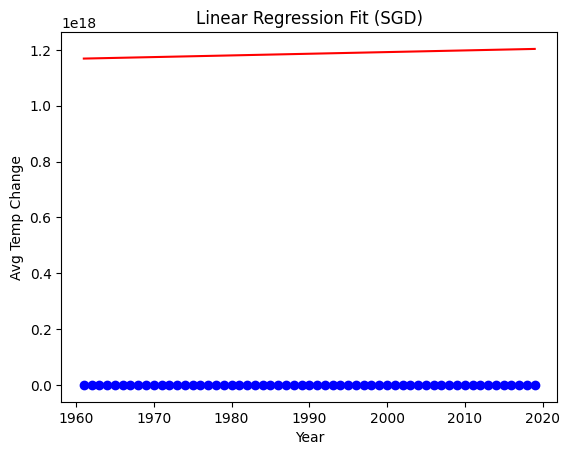

In [ ]:
plt.scatter(X, y, color='blue')
plt.plot(X, sgd.predict(X), color='red')
plt.xlabel('Year')
plt.ylabel('Avg Temp Change')
plt.title('Linear Regression Fit (SGD)')
plt.show()


Residual Distribution

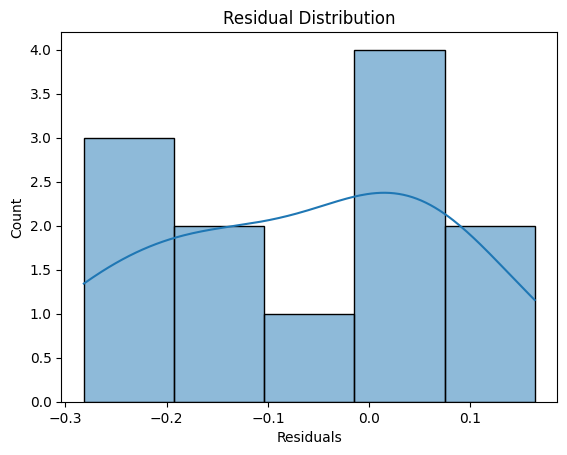

In [ ]:
predictions = models[best_model_name].predict(X_test)
sns.histplot(predictions - y_test, kde=True)
plt.xlabel('Residuals')
plt.title('Residual Distribution')
plt.show()


FastAPI Prediction Endpoint

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel, Field
from fastapi.middleware.cors import CORSMiddleware
import uvicorn
import joblib
import os
import nest_asyncio

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

class InputData(BaseModel):
    year: int = Field(..., ge=1960, le=2030)

@app.post("/predict")
def predict(data: InputData):
    model_path = "Random Forest.pkl"  # use best_model_name + '.pkl'

    if not os.path.exists(model_path):
        return {"error": f"Model file '{model_path}' not found."}

    try:
        model = joblib.load(model_path)
    except Exception as e:
        return {"error": f"Error loading model: {str(e)}"}

    input_data = [[data.year]]
    try:
        prediction = model.predict(input_data)[0]
        return {"prediction": prediction}
    except Exception as e:
        return {"error": f"Prediction error: {str(e)}"}

if __name__ == "__main__":
    nest_asyncio.apply()
    uvicorn.run(app, host="0.0.0.0", port=8000)




ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-7' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:69> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/main.py", line 580, in run
    server.run()
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 67, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    se